# Generate feature visualization through optimization

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/PIF-revision/patch_individual_filters/")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import h5py
import nibabel as nib
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nitorch.data import load_nifti
from nitorch.transforms import ToTensor
from pif import PatchIndividualFilters3D

sys.path.insert(0,"/analysis/fabiane/phd/Pytorch-LRP/")
from innvestigator import InnvestigateModel
from jrieke import interpretation

### Parameters

Use the best model from the first outer fold. I.e. the one that we measured against the test set.

In [6]:
gpu = 2
model_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/10xrandom_splits/experiment_r2/"
model_path = os.path.join(model_dir,"outer_0_inner_4_cv_fold_4_BEST_ITERATION.h5")
heatmap_dir = model_dir.replace("models", "heatmaps")

In [7]:
!mkdir -p $heatmap_dir

### Model definition

In [8]:
from experiments.models_ukb import ModelBPIF

In [9]:
# load pre-trained weights
net = ModelBPIF()
net.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
net = net.cuda(gpu)
net.eval()

ModelBPIF(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_1): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_2): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_3): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_4): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_5): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_6): Conv3d(64, 6, kernel_size=(3, 3, 3), 

In [10]:
neuron = list(dict(net.named_children())["Conv_1"].parameters())[0][0]

### Load several images

In [11]:
n_imgs = 5
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"
df = pd.read_csv(table)
# shuffle the dataset
df = df.sample(frac=1, random_state=23)

In [12]:
X = np.zeros(shape=(n_imgs, 182, 218, 182))
y = np.zeros(shape=(n_imgs))
for idx in range(n_imgs):
    path = df.iloc[idx]['file_path']
    path = path.replace("/analysis/ritter", "/ritter/share")
    image = load_nifti(path)
    X[idx] = image
    y[idx] = df.iloc[idx]['Sex'] == "Male"

In [13]:
# get nifti information of first image
path = df.iloc[idx]['file_path']
path = path.replace("/analysis/ritter", "/ritter/share")
image, nifti = load_nifti(path, incl_header=True)

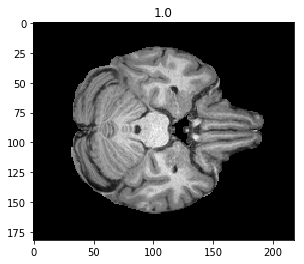

In [15]:
plt.imshow(X[1,:,:,48], cmap='gray')
plt.title(y[1])
plt.show()

In [16]:
# normalize the images
for i, img in enumerate(X):
    X[i] = img / np.max(img)
X = torch.Tensor(X)

# LRP

In [20]:
# load pre-trained weights
flatnet = ModelBPIF()

new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
print("Start with linear layers..")
flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
pif.conv_0.weight
pif.conv_0.bias
pif.conv_1.weight
pif.conv_1.bias
pif.conv_2.weight
pif.conv_2.bias
pif.conv_3.weight
pif.conv_3.bias
pif.conv_4.weight
pif.conv_4.bias
pif.conv_5.weight
pif.conv_5.bias
pif.conv_6.weight
pif.conv_6.bias
pif.conv_7.weight
pif.conv_7.bias
pif.conv_ov_0.weight
pif.conv_ov_0.bias
classifier_scratch.0.weight
classifier_scratch.0.bias
classifier_scratch.2.weight
classifier_scratch.2.bias
Start with linear layers..


In [21]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): ModelBPIF(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (pif): PatchIndividualFilters3D(
        (conv_0): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_1): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_2): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_3): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_4): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_5):

In [22]:
def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=0)

In [23]:
idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[idx], 0), 0).cuda(gpu))
AD_score = AD_score[0][0].detach().cpu().numpy()
LRP_map = LRP_map.detach().numpy().squeeze()

# save result on disk
lrp_layer = "score"

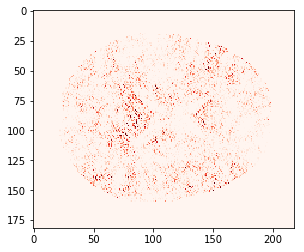

In [24]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

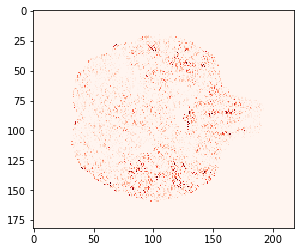

In [25]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
plt.imshow(LRP_map[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

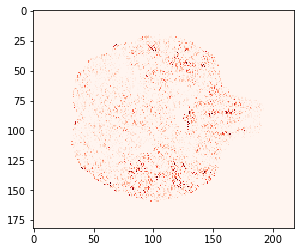

In [26]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
plt.imshow(LRP_map[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

## Use PIF layer as output

In [27]:
lrp_layer = "pif_layer" # used only for output file naming

In [28]:
class ModelBPIF(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(ModelBPIF, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 32, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_3 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)

        self.pif = PatchIndividualFilters3D([8,10,8],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=6,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = self.pool_3(x)
        if print_size:
            print(x.shape)
        h = F.elu(self.pif(x))
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [30]:
# load pre-trained weights
flatnet = ModelBPIF()

new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
pif.conv_0.weight
pif.conv_0.bias
pif.conv_1.weight
pif.conv_1.bias
pif.conv_2.weight
pif.conv_2.bias
pif.conv_3.weight
pif.conv_3.bias
pif.conv_4.weight
pif.conv_4.bias
pif.conv_5.weight
pif.conv_5.bias
pif.conv_6.weight
pif.conv_6.bias
pif.conv_7.weight
pif.conv_7.bias
pif.conv_ov_0.weight
pif.conv_ov_0.bias


In [31]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): ModelBPIF(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (pif): PatchIndividualFilters3D(
        (conv_0): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_1): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_2): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_3): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_4): Conv3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_5):

In [32]:
def run_LRP(net, image_tensor, output_loc=np.index_exp[:, 5, 8, 0, 0, 0]):
    #return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=10499)
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=output_loc)

In [33]:
img_idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
print("output shape: {}".format(AD_score.shape))

LRP_map = LRP_map.detach().numpy().squeeze()

output shape: torch.Size([1, 6, 9, 3, 3, 3])


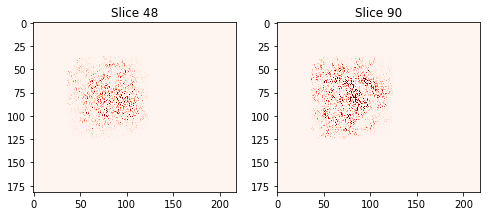

In [34]:
# visualize two slices
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
ax[0].imshow(LRP_map[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
ax[0].set_title("Slice 48")
ax[1].imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
ax[1].set_title("Slice 90")
fig.show()

####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 1 

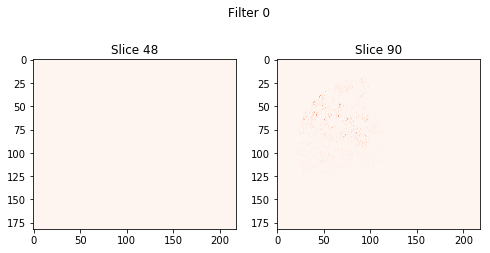

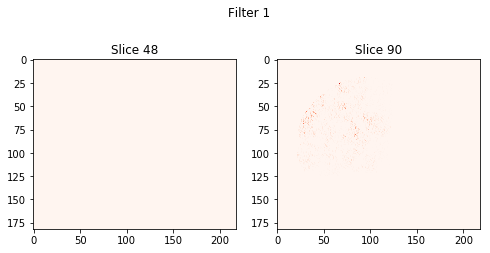

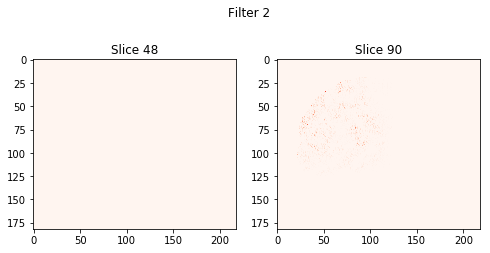

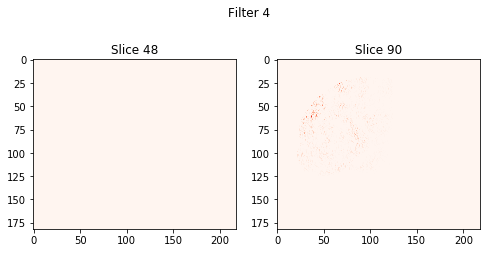

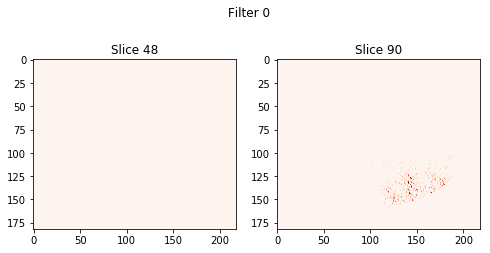

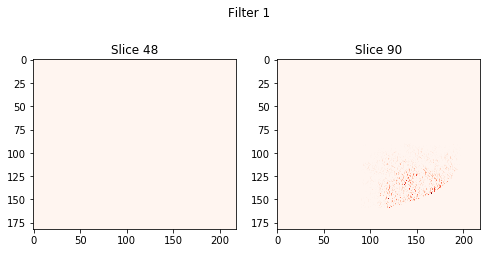

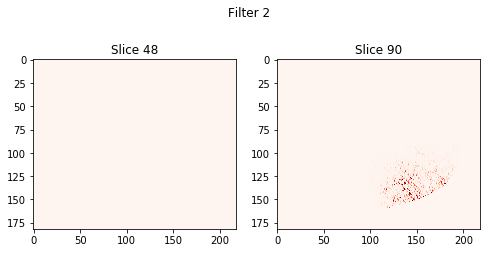

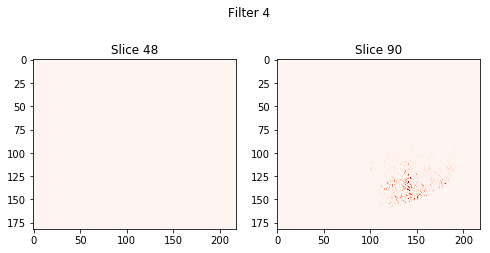

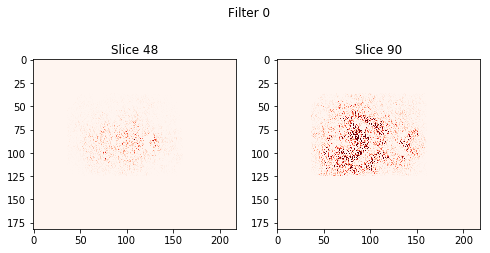

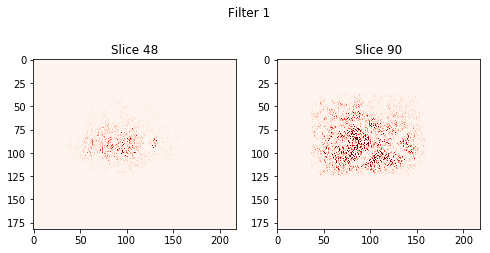

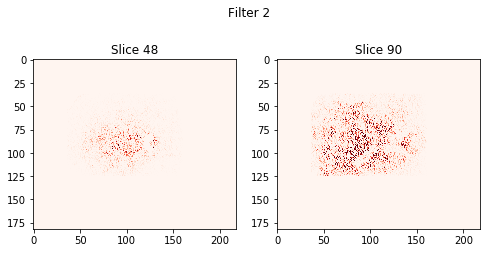

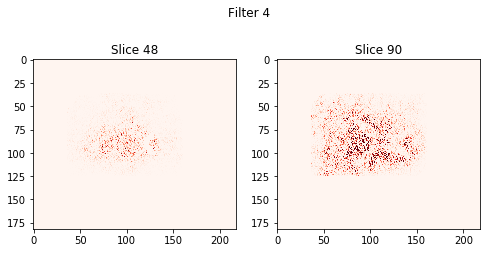

In [36]:
for patch_pos in [1, 7, 8]:
    for filter_pos in [0, 1, 2, 4]:
        print("####### Next Filter #######")
        feature_map_shape = [3, 3, 3]
        img_idx = 0
        img = torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu)
        LRP_maps = np.zeros(shape=X.shape[1:])
        for x in range(feature_map_shape[0]):
            for y in range(feature_map_shape[1]):
                for z in range(feature_map_shape[2]):
                    print(x, y, z)
                    AD_score, LRP_map = run_LRP(inn_model, 
                                                img,
                                                output_loc=np.index_exp[0, filter_pos, patch_pos, x, y, z])
                    LRP_map = LRP_map.detach().cpu().numpy().squeeze()
                    LRP_maps += LRP_map

        # visualize two slices
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
        ax[0].imshow(LRP_maps[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
        ax[0].set_title("Slice 48")
        ax[1].imshow(LRP_maps[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
        ax[1].set_title("Slice 90")
        fig.suptitle("Filter {}".format(filter_pos))
        fig.show()

        # save result on disk
        res_nifti = nib.Nifti1Image(LRP_maps, nifti.affine, header=nifti.header)
        nib.save(res_nifti, os.path.join(heatmap_dir, "LRP_latent-feature-map_visualization_Layer-{}_Patch-{}_Filter-{}.nii.gz".format(lrp_layer, patch_pos, filter_pos)))

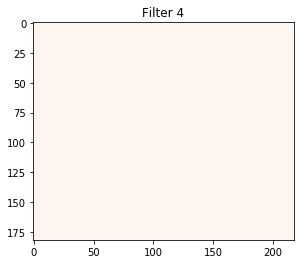

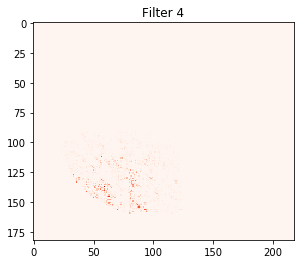

In [57]:
vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
plt.imshow(LRP_maps[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
plt.imshow(LRP_maps[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

## Use conv 3 layer as output

In [61]:
lrp_layer = "Conv3" # used only for output file naming

In [67]:
class ModelBPIF(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(ModelBPIF, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 32, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_3 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = self.pool_3(x)
        return x

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [69]:
# load pre-trained weights
flatnet = ModelBPIF()

new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias


In [70]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): ModelBPIF(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sigmoid()
  )
)

In [71]:
def run_LRP(net, image_tensor, output_loc=np.index_exp[:, 4, 2, 4, 3]):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=output_loc)

In [72]:
img_idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
print("output shape: {}".format(AD_score.shape))
LRP_map = LRP_map.detach().numpy().squeeze()

output shape: torch.Size([1, 64, 8, 10, 8])


####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 6
1 5 7
1 6 0
1 6 1
1 6 2
1 6 3
1 6 4
1 6 5
1 6 6
1 6 7
1 7 0
1 7 1
1 7 2
1 7 3
1 7 4
1 7 5
1 7 6
1 7 7
1 8 0
1 8 1
1 8 2
1 8 3
1 8 4
1 8 5
1 8 6
1 8 7
1 9 0
1 9 1
1 9 2
1 9 3
1 9 4
1 9 5
1 9 6
1 9 7
2 0 0
2 0 1


0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 6
1 5 7
1 6 0
1 6 1
1 6 2
1 6 3
1 6 4
1 6 5
1 6 6
1 6 7
1 7 0
1 7 1
1 7 2
1 7 3
1 7 4
1 7 5
1 7 6
1 7 7
1 8 0
1 8 1
1 8 2
1 8 3
1 8 4
1 8 5
1 8 6
1 8 7
1 9 0
1 9 1
1 9 2
1 9 3
1 9 4
1 9 5
1 9 6
1 9 7
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 3 7
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
2 4 5
2 4 6
2 4 7
2 5 0
2 5 1
2 5 2
2 5 3
2 5 4
2 5 5
2 5 6
2 5 7
2 6 0
2 6 1
2 6 2
2 6 3
2 6 4
2 6 5
2 6 6
2 6 7
2 7 0
2 7 1
2 7 2
2 7 3
2 7 4
2 7 5
2 7 6
2 7 7
2 8 0
2 8 1
2 8 2
2 8 3
2 8 4
2 8 5
2 8 6
2 8 7
2 9 0
2 9 1
2 9 2
2 9 3
2 9 4
2 9 5
2 9 

1 8 5
1 8 6
1 8 7
1 9 0
1 9 1
1 9 2
1 9 3
1 9 4
1 9 5
1 9 6
1 9 7
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 3 7
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
2 4 5
2 4 6
2 4 7
2 5 0
2 5 1
2 5 2
2 5 3
2 5 4
2 5 5
2 5 6
2 5 7
2 6 0
2 6 1
2 6 2
2 6 3
2 6 4
2 6 5
2 6 6
2 6 7
2 7 0
2 7 1
2 7 2
2 7 3
2 7 4
2 7 5
2 7 6
2 7 7
2 8 0
2 8 1
2 8 2
2 8 3
2 8 4
2 8 5
2 8 6
2 8 7
2 9 0
2 9 1
2 9 2
2 9 3
2 9 4
2 9 5
2 9 6
2 9 7
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 0 5
3 0 6
3 0 7
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
3 4 5
3 4 6
3 4 7
3 5 0
3 5 1
3 5 2
3 5 3
3 5 4
3 5 5
3 5 6
3 5 7
3 6 0
3 6 1
3 6 2
3 6 3
3 6 4
3 6 5
3 6 6
3 6 7
3 7 0
3 7 1
3 7 2
3 7 3
3 7 4
3 7 5
3 7 6
3 7 7
3 8 0
3 8 1
3 8 2
3 8 3
3 8 4
3 8 5
3 8 6
3 8 7
3 9 0
3 9 1
3 9 2
3 9 

2 8 2
2 8 3
2 8 4
2 8 5
2 8 6
2 8 7
2 9 0
2 9 1
2 9 2
2 9 3
2 9 4
2 9 5
2 9 6
2 9 7
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 0 5
3 0 6
3 0 7
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
3 4 5
3 4 6
3 4 7
3 5 0
3 5 1
3 5 2
3 5 3
3 5 4
3 5 5
3 5 6
3 5 7
3 6 0
3 6 1
3 6 2
3 6 3
3 6 4
3 6 5
3 6 6
3 6 7
3 7 0
3 7 1
3 7 2
3 7 3
3 7 4
3 7 5
3 7 6
3 7 7
3 8 0
3 8 1
3 8 2
3 8 3
3 8 4
3 8 5
3 8 6
3 8 7
3 9 0
3 9 1
3 9 2
3 9 3
3 9 4
3 9 5
3 9 6
3 9 7
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 2 5
4 2 6
4 2 7
4 3 0
4 3 1
4 3 2
4 3 3
4 3 4
4 3 5
4 3 6
4 3 7
4 4 0
4 4 1
4 4 2
4 4 3
4 4 4
4 4 5
4 4 6
4 4 7
4 5 0
4 5 1
4 5 2
4 5 3
4 5 4
4 5 5
4 5 6
4 5 7
4 6 0
4 6 1
4 6 2
4 6 3
4 6 4
4 6 5
4 6 6
4 6 7
4 7 0
4 7 1
4 7 2
4 7 3
4 7 4
4 7 5
4 7 6
4 7 7
4 8 0
4 8 1
4 8 2
4 8 3
4 8 4
4 8 5
4 8 6
4 8 7
4 9 

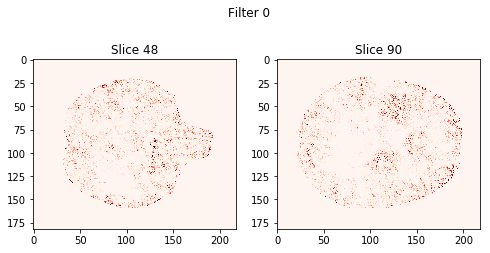

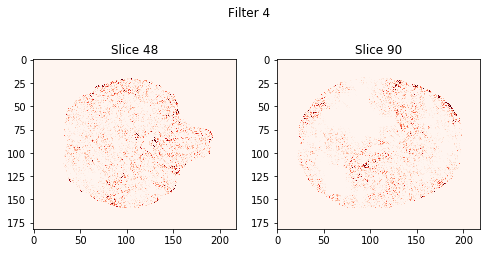

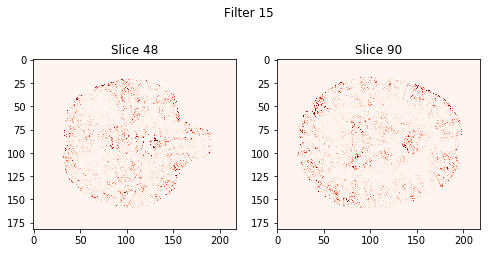

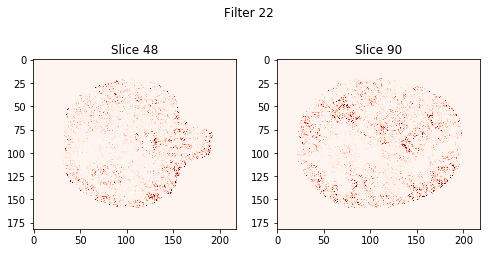

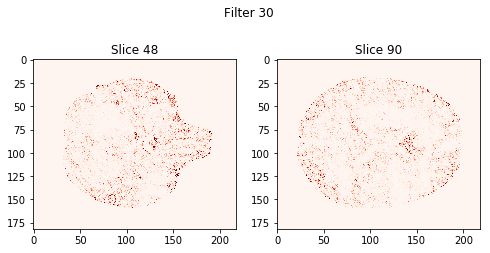

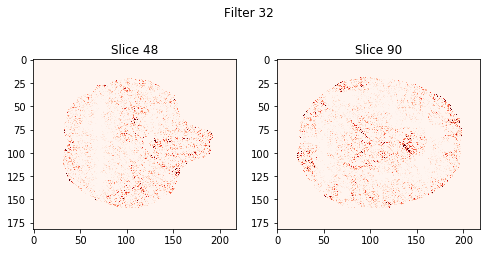

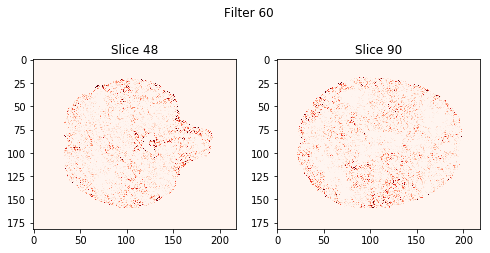

In [73]:
for filter_pos in [0, 4 ,15, 22, 30, 32, 60]:
    print("####### Next Filter #######")
    feature_map_shape = [8, 10, 8]
    img_idx = 0
    img = torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu)
    LRP_maps = np.zeros(shape=X.shape[1:])
    for x in range(feature_map_shape[0]):
        for y in range(feature_map_shape[1]):
            for z in range(feature_map_shape[2]):
                print(x, y, z)
                AD_score, LRP_map = run_LRP(inn_model, 
                                            img,
                                            output_loc=np.index_exp[0, filter_pos, x, y, z])
                LRP_map = LRP_map.detach().cpu().numpy().squeeze()
                LRP_maps += LRP_map

    # visualize two slices
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
    ax[0].imshow(LRP_maps[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
    ax[0].set_title("Slice 48")
    ax[1].imshow(LRP_maps[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
    ax[1].set_title("Slice 90")
    fig.suptitle("Filter {}".format(filter_pos))
    fig.show()
    
    # save result on disk
    res_nifti = nib.Nifti1Image(LRP_maps, nifti.affine, header=nifti.header)
    nib.save(res_nifti, os.path.join(heatmap_dir, "LRP_latent-feature-map_visualization_Layer-{}_Filter-{}.nii.gz".format(lrp_layer, filter_pos)))

In [ ]:
vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
plt.imshow(LRP_maps[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
plt.imshow(LRP_maps[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
plt.imshow(LRP_maps[:,:,56], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
plt.imshow(LRP_maps[:,:,72], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

# Backpropagate from feature map

In [ ]:
std = torch.Tensor([0.05, 0.05, 0.05, 0.05]).repeat(4,4,1).unsqueeze(0)
gaussian_kernel = torch.normal(mean=1, std=std).unsqueeze(0)

In [ ]:
gaussian_kernel.shape

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.blur = blur_kernel
        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

In [ ]:
new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

In [ ]:
sub_model.load_state_dict(new_state_dict)

In [ ]:
sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
X = X.requires_grad_()

In [ ]:
sub_model.zero_grad()

In [ ]:
res = sub_model.forward(torch.unsqueeze(X, 1).cuda(gpu))

In [ ]:
plt.imshow(saver.get_activation()[5].cpu().numpy()[:,:,5])
plt.show()

In [ ]:
res_img = res[1].cpu().detach().numpy()

In [ ]:
for filter_pos in range(5):
    plt.imshow(res_img[filter_pos][:,:,5])
    plt.show()

In [ ]:
res.shape

In [ ]:
image_pos = 1
filter_pos = 20

In [ ]:
grad = torch.mean(torch.abs(res[image_pos, filter_pos]))

In [ ]:
grad.backward()

In [ ]:
print(torch.sum(X.grad))

In [ ]:
print(torch.sum(X.grad))

In [ ]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

In [ ]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

In [ ]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

### Optimization loop

In [ ]:
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

smoothed = F.conv3d(base, weight=gaussian_kernel, stride=1)
plt.imshow(smoothed.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 10

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 43

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 43

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
res = sub_model.forward(base.cuda(gpu))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos]))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos-14]))

In [ ]:
res = sub_model.forward(torch.unsqueeze(X[[0]], 1).cuda(gpu))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos]))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos-14]))

In [ ]:
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Using PIF Layer as output

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.pif = PatchIndividualFilters3D([10,13,10],
                                    filter_shape=(3,3,3),
                                    patch_shape=(5,5,5),
                                    num_local_filter_in=64,
                                    num_local_filter_out=3,
                                    overlap=1,
                                    reassemble=False,
                                    debug=False)
        

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        x = F.elu(self.pif(x))
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
filter_pos = 1

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 2

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()